In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### treniraj yolov8 na handgrid datasetu
# !git clone https://github.com/hukenovs/hagrid.git


Cloning into 'hagrid'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 260 (delta 88), reused 91 (delta 54), pack-reused 99
Receiving objects: 100% (260/260), 8.96 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
# %cd hagrid

/content/hagrid


In [ ]:
# !pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... canceledERROR: Operation cancelled by user


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.6/749.6 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# !python hagrid/download.py -a -d -t palm no_gesture -p .

In [ ]:
# %cd ..

/content


In [ ]:
# %rm -r hagrid

In [3]:
# download dataset from gdrive
!gdown 1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK -O hagrid.zip


Downloading...
From (original): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK
From (redirected): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK&confirm=t&uuid=6536c7f3-6bf8-458a-9dbb-9b4f85c03cc3
To: /content/hagrid.zip
100% 1.90G/1.90G [00:19<00:00, 96.5MB/s]


In [4]:
import os
import zipfile
zip_file_path = os.path.join('.', 'hagrid.zip')
dataset_dir = "hagrid"
# extract downloaded zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

os.remove(zip_file_path)

In [5]:
%rm -rf hagrid/__MACOSX/

In [6]:
hagrid_micro_dir = os.path.join(dataset_dir, 'HG_micro_3class')
%cat {hagrid_micro_dir}/data.yaml

train: hagrid/HG_micro_3class/train/images
val: hagrid/HG_micro_3class/valid/images
test: hagrid/HG_micro_3class/test/images

nc: 3
names: [fist,palm,no_gesture]


In [25]:
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Rotate(limit=(-45, 45), p=0.8), 
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2), 
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  

    # A.Rotate(limit=(-90, 90), p=0.8),
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    # A.RGBShift(p=0.2),
    # A.Perspective(scale=(0.05, 0.1), p=0.5),
    # A.MotionBlur(blur_limit=(3, 7), p=0.5),
    # A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    # A.Cutout(num_holes=8, max_h_size=16, max_w_size=16, fill_value=0, p=0.5),
], bbox_params=A.BboxParams(format='yolo'))

In [27]:

def augment_image_and_labels(image_path, label_path):
    image = cv2.imread(image_path) 
    with open(label_path, 'r') as f:
        label = f.readline().strip().split(' ')
    class_label = int(label[0]) 
    bounding_box = list(map(float, label[1:])) 
    transformed = transform(image=image, bboxes=[bounding_box + [class_label]])
    augmented_image = transformed['image']
    augmented_bbox = transformed['bboxes']
    return augmented_image, augmented_bbox, class_label


dataset_dir = "/content/hagrid/HG_micro_3class/"
train_dir = "train"
valid_dir = "valid"
test_dir = "test"


def augment_images_in_dir(directory):
    image_dir = os.path.join(dataset_dir, directory, "images")
    label_dir = os.path.join(dataset_dir, directory, "labels")
    augmented_images_dir = os.path.join("/content/datasets/", "augmented", directory, "images")
    augmented_labels_dir = os.path.join("/content/datasets/", "augmented", directory, "labels")
    os.makedirs(augmented_images_dir, exist_ok=True)
    os.makedirs(augmented_labels_dir, exist_ok=True)
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = f.readline().strip().split(' ')
                class_label = int(label[0]) 
            # if class_label != 1:
            #     continue
            augmented_image, augmented_bbox, class_label = augment_image_and_labels(image_path, label_path) ## prebaci sa kraja na pocetak
            if augmented_bbox:
              augmented_image_path = os.path.join(augmented_images_dir, filename)
              augmented_label_path = os.path.join(augmented_labels_dir, filename.replace(".jpg", ".txt"))
              cv2.imwrite(augmented_image_path, augmented_image)
              with open(augmented_label_path, 'w') as f:
                  for bbox in augmented_bbox:
                    reordered_bbox = [bbox[-1]] + list(bbox[:-1])
                    bbox_str = ' '.join(map(str, reordered_bbox))
                    f.write(f"{bbox_str}\n")

              print(f"Augmented image saved: {augmented_image_path}")

augment_images_in_dir(train_dir)
augment_images_in_dir(valid_dir)
augment_images_in_dir(test_dir)

print("Dataset augmentation completed.")


Augmented image saved: /content/datasets/augmented/train/images/0d5723bf-cdd4-4b2d-9353-1dfc7b266205.jpg
Augmented image saved: /content/datasets/augmented/train/images/0cebd859-483a-4ca2-b0aa-bee309491387.jpg
Augmented image saved: /content/datasets/augmented/train/images/0e2b1277-e44f-4763-86a6-cec4b56f171c.jpg
Augmented image saved: /content/datasets/augmented/train/images/0c5044d1-0aeb-4444-9e6b-8029e89e05fb.jpg
Augmented image saved: /content/datasets/augmented/train/images/0a263b65-9922-4e20-92e3-319ef608ff3a.jpg
Augmented image saved: /content/datasets/augmented/train/images/0c057426-8b08-4062-8172-a4f39d8bc800.jpg
Augmented image saved: /content/datasets/augmented/train/images/0a89482f-91ec-444e-9444-17d17f34a5b0.jpg
Augmented image saved: /content/datasets/augmented/train/images/0d2ce34d-c2f9-44eb-bd88-25543d243d06.jpg
Augmented image saved: /content/datasets/augmented/train/images/0d934060-224d-4809-b211-40c23186c3ce.jpg
Augmented image saved: /content/datasets/augmented/trai

In [10]:
!pip install pybboxes

In [11]:
### CODE FOR SHOWING IMAGE WITH BBOX


from google.colab.patches import cv2_imshow
import pybboxes as pbx

# transformed_bboxes
# cv2_imshow(transformed_image)

img_path = "/content/hagrid/augmented/test/images/0c20953f-f5f3-4888-bbf6-fb78ff09fe06.jpg"
label_path = "/content/hagrid/augmented/test/labels/0c20953f-f5f3-4888-bbf6-fb78ff09fe06.txt"
with open(label_path, 'r') as f:
    bboxes = [line.strip().split() for line in f.readlines()]
img = cv2.imread(img_path)
print(bboxes)

H, W = img.shape[:2]
# for label in bboxes:
#     label = map(int, label)
#     yolo_normalized = label[1:]
#     box_voc = pbx.convert_bbox(tuple(yolo_normalized), from_type="yolo", to_type="voc", image_size=(W, H))
#     cv2.rectangle(img, (box_voc[0], box_voc[1]),
#                   (box_voc[2], box_voc[3]), (0, 0, 255), 1)

for bbox in bboxes:
    _, x_center, y_center, width, height = map(float, bbox)
    box_voc = pbx.convert_bbox(tuple([x_center, y_center, width, height]), from_type="yolo", to_type="voc", image_size=(W, H))
    cv2.rectangle(img, (box_voc[0], box_voc[1]), (box_voc[2], box_voc[3]), (0, 0, 255), 1)  # Adjusted line thickness for visibility


cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
!du -sh /content/hagrid/augmented
!du -sh /content/hagrid/HG_micro_3class
!find /content/hagrid/augmented -type f | wc -l
!find /content/hagrid/HG_micro_3class -type f | wc -l
!du -sh /content/hagrid/augmented/test/images/1b663c79-fae7-4767-984f-7aa96a499c95.jpg
!du -sh /content/hagrid/HG_micro_3class/test/images/1b663c79-fae7-4767-984f-7aa96a499c95.jpg

448M	/content/hagrid/augmented
1.8G	/content/hagrid/HG_micro_3class
1214
2806
932K	/content/hagrid/augmented/test/images/1b663c79-fae7-4767-984f-7aa96a499c95.jpg
1.2M	/content/hagrid/HG_micro_3class/test/images/1b663c79-fae7-4767-984f-7aa96a499c95.jpg


In [28]:
# dodaj data.yaml fajl
!cp -r /content/hagrid/HG_micro_3class/data.yaml /content/datasets/augmented/data.yaml

In [16]:
!ls  /content/hagrid/augmented
!mkdir datasets
!cp -r /content/hagrid/augmented /content/datasets/


data.yaml  test  train	valid


In [ ]:
### FOR TESTING

#### LABEL MORA DA SE PREBACI SA POCETKA FAJLA NA KRAJ, TO MOZE DA SE URADI KADA SE UCITAVA FAJL
# transform = A.Compose([
#     A.Rotate(limit=(-180, 180),p=1),
#     A.HorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
#     A.RandomBrightnessContrast(p=0.2),  # Randomly change brightness and contrast
#     A.RGBShift(p=0.2)
# ], bbox_params=A.BboxParams(format='yolo'))

transform = A.Compose([
    A.Rotate(limit=(-90, 90), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(p=0.2),
    A.Perspective(scale=(0.05, 0.1), p=0.5),
    A.MotionBlur(blur_limit=(3, 7), p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Cutout(num_holes=8, max_h_size=16, max_w_size=16, fill_value=0, p=0.5),
], bbox_params=A.BboxParams(format='yolo'))



# image = cv2.imread("/content/hagrid/HG_micro_3class/test/images/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.jpg")
image = cv2.imread("/content/hagrid/HG_micro_3class/test/images/0a1256be-be66-410a-bb6c-23e4f199f4a0.jpg")

# with open('/content/hagrid/HG_micro_3class/test/labels/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.txt', 'r') as file:
with open('/content/hagrid/HG_micro_3class/test/labels/0a1256be-be66-410a-bb6c-23e4f199f4a0.txt', 'r') as file:
    first_line = file.readline().strip()
    numbers_str = first_line.split()
    numbers_list = [float(num) for num in numbers_str]
    bboxes=[numbers_list[1:] + [numbers_list[0]]]
# bboxes=[[ 0.60109521, 0.6672750000000001, 0.14663042, 0.12826, 'palm']]
print(bboxes)
transformed = transform(image=image, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']


[[0.62748256, 0.22956548499999999, 0.10996596, 0.08544437, 0.0]]


In [ ]:
### FOR TESTING
reordered_bbox = [transformed_bboxes[-1]] + list(transformed_bboxes[:-1])
# Convert each element to string and join with space separator
bbox_str = ' '.join(map(str, reordered_bbox))
print(reordered_bbox)
print(bbox_str)

[(0.20146910326273318, 0.25782889622221183, 0.155942547120748, 0.13386139759032217, 0.0)]
(0.20146910326273318, 0.25782889622221183, 0.155942547120748, 0.13386139759032217, 0.0)


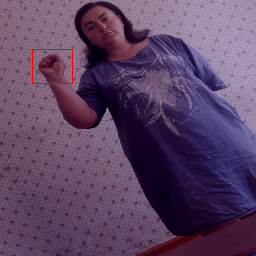

In [ ]:
### FOR TESTING

from google.colab.patches import cv2_imshow
import pybboxes as pbx

# transformed_bboxes
# cv2_imshow(transformed_image)


H, W = transformed_image.shape[:2]
for label in transformed_bboxes:
    yolo_normalized = label[0:-1]
    box_voc = pbx.convert_bbox(tuple(yolo_normalized), from_type="yolo", to_type="voc", image_size=(W, H))
    cv2.rectangle(transformed_image, (box_voc[0], box_voc[1]),
                  (box_voc[2], box_voc[3]), (0, 0, 255), 1)
cv2_imshow(transformed_image)
# cv2.imwrite('/content/hagrid/1.jpg', transformed_image)


In [14]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()


In [ ]:
# Sacuvaj lokalno
!cp -r /content/hagrid/augmented /content/drive/MyDrive/rivian/yolov8/augmented



In [ ]:
%pwd

'/content'

In [ ]:
### treba da se stavi dataset u /content/datasets/
!cp -r /content/drive/MyDrive/rivian/yolov8/augmented /content/datasets/hagrid_augmented/

In [ ]:
!mv  /augmented /content/datasets/

In [29]:
### TRAIN
### SETUP data.yaml before!
# train: /content/datasets/augmented/train/images
# val: /content/datasets/augmented/valid/images
# test: /content/datasets/augmented/test/images

# nc: 1
# names: ['palm']
!yolo task=detect mode=train model=yolov8l.pt data=/content/datasets/augmented/data.yaml epochs=15 batch=-1

Ultralytics YOLOv8.1.45 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/datasets/augmented/data.yaml, epochs=15, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

In [24]:
!yolo task=detect mode=predict model=/content/runs/detect/train3/weights/best.pt data=/content/datasets/augmented/data.yaml

WARNING ⚠️ 'source' argument is missing. Using default 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.
Ultralytics YOLOv8.1.45 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 111.5ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 1 palm, 77.2ms
Speed: 2.7ms preprocess, 94.3ms inference, 1026.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
!cp -r /content/runs/detect/train4 /content/drive/MyDrive/rivian/yolov8/augmented_weight/

In [ ]:
!yolo